In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from joblib import dump, load
import torch

In [2]:
df = json.load(open('/voyager/datasets/UCI/uci_heart_processed.json'))
keys = ["age", "sex", "chest pain type", "resting blood pressure", "serum \
cholestoral", "fasting blood sugar", "resting electrocardiographic \
results", "maximum heart rate achieved", "exercise induced angina", "angiographic disease status"]

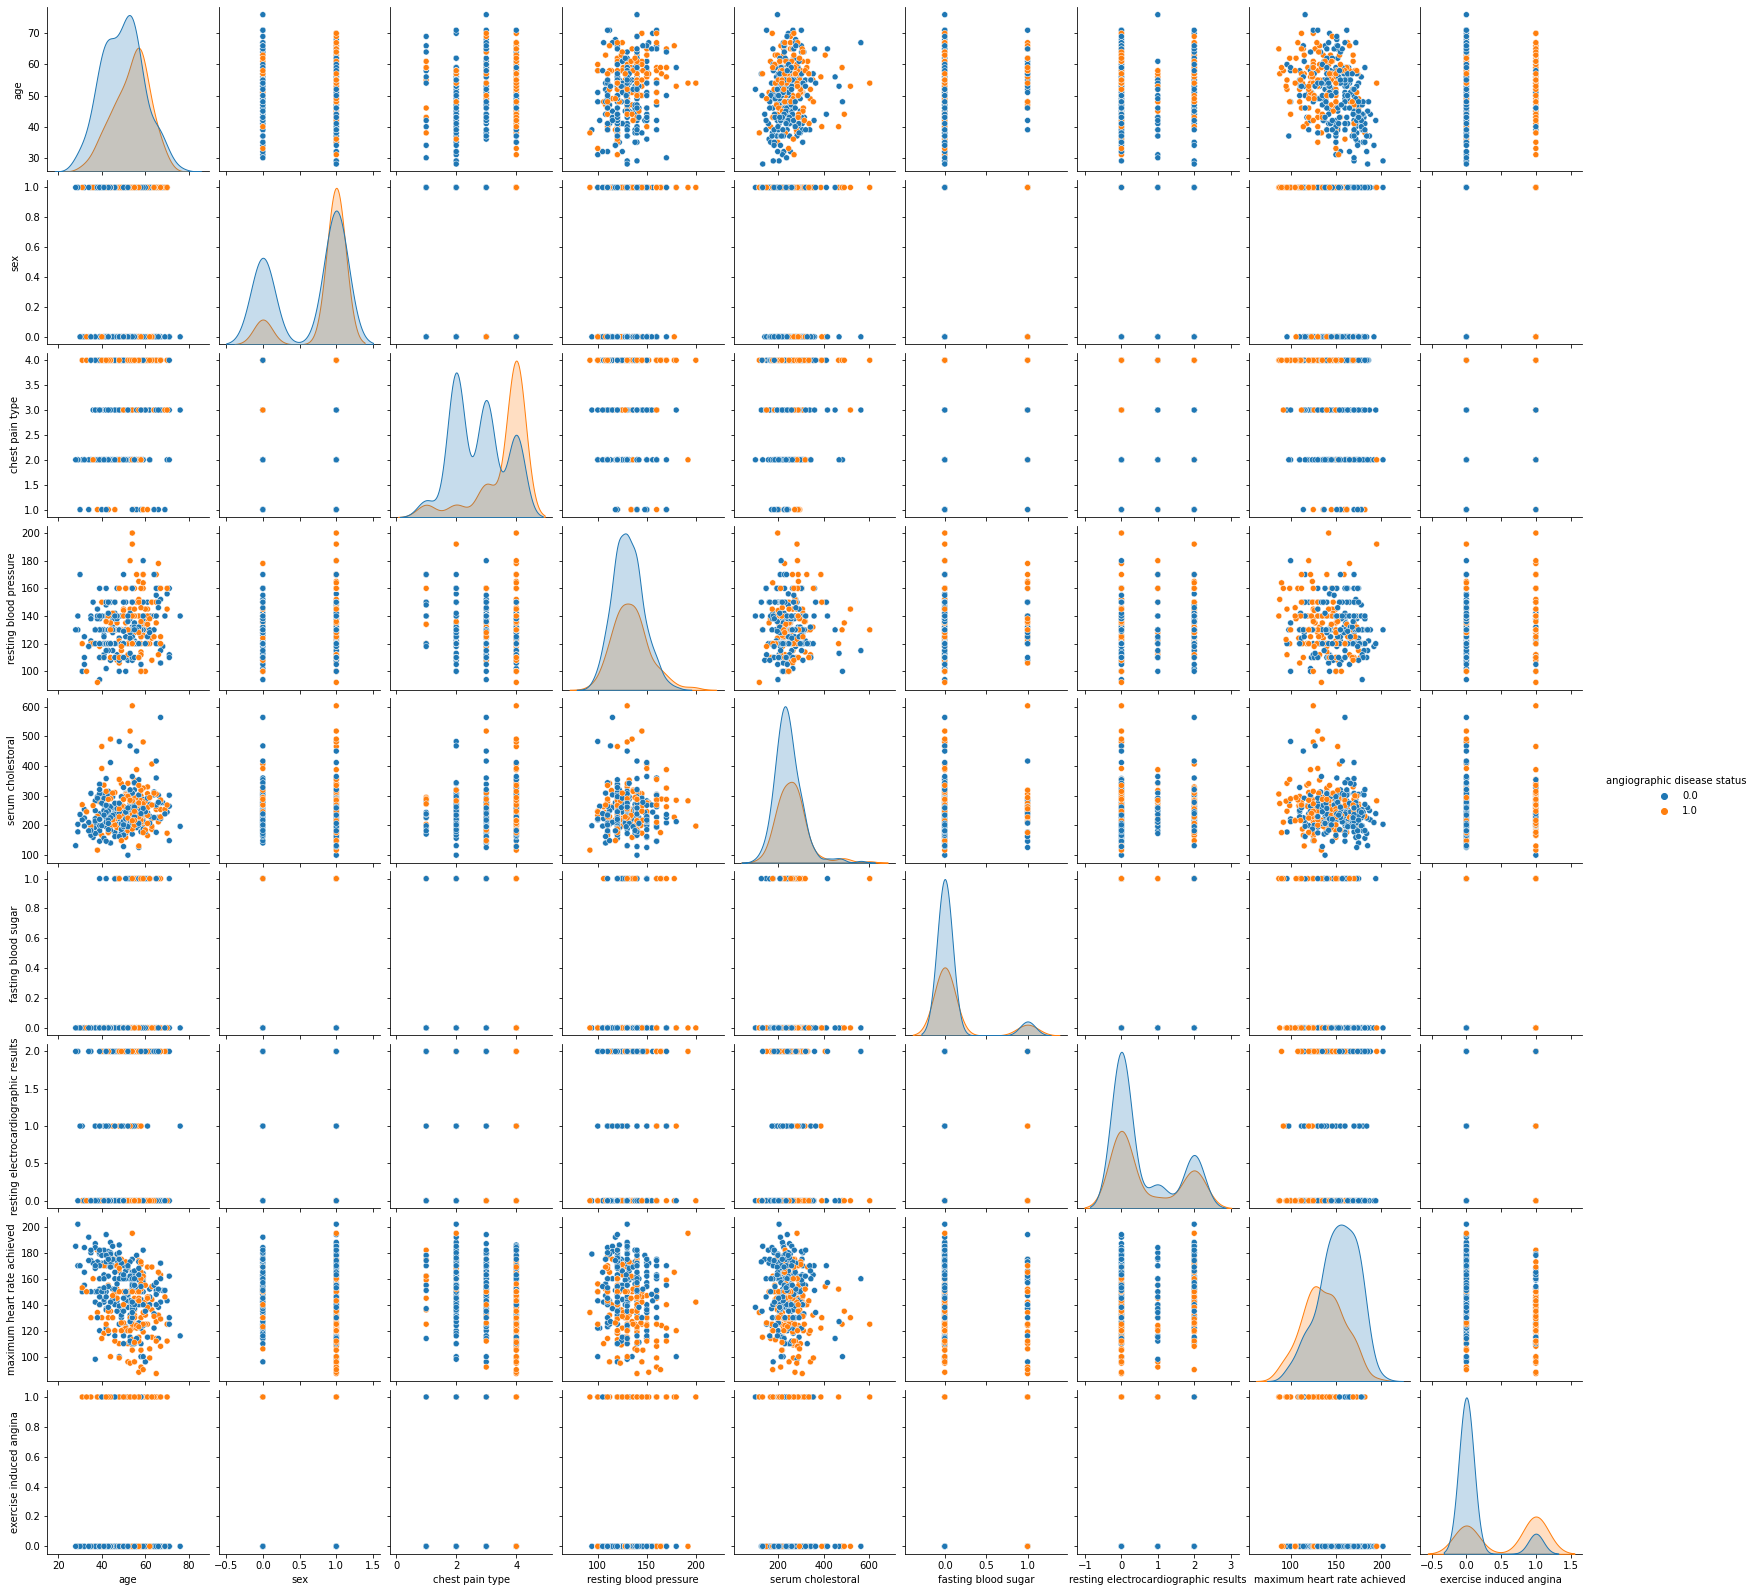

In [24]:
train = pd.DataFrame(np.hstack([np.array(df['train'][0]), np.array(df['train'][1])[:, None]]), columns=keys)
sns.pairplot(train, hue='angiographic disease status')

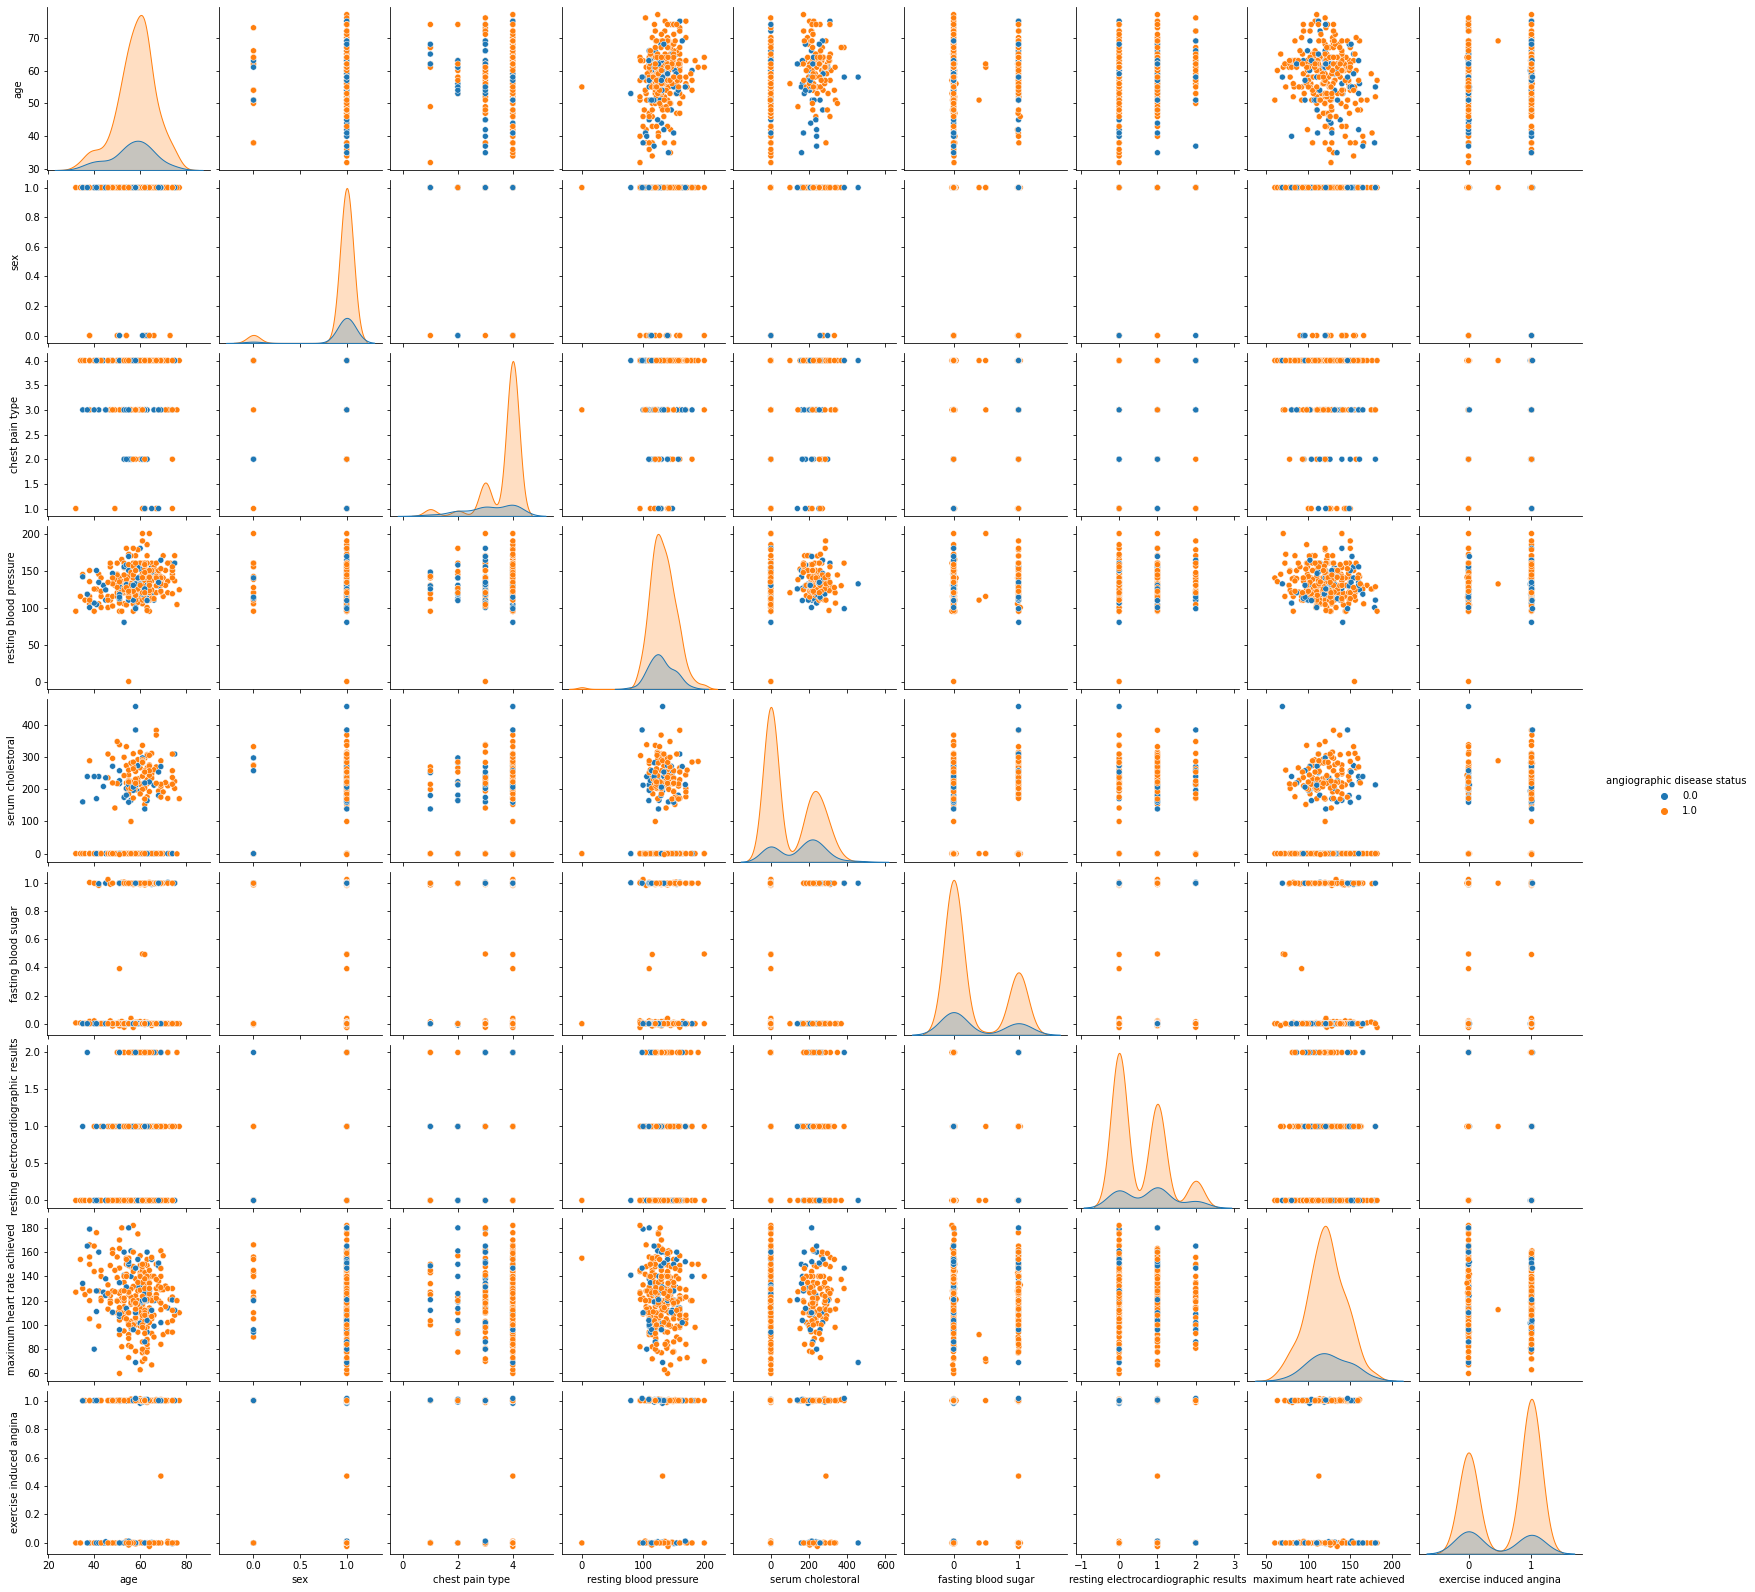

In [26]:
test = pd.DataFrame(np.hstack([np.array(df['ood_test'][0]), np.array(df['ood_test'][1])[:, None]]), columns=keys)
sns.pairplot(test, hue='angiographic disease status')

In [3]:
for key in df.keys():
    data, labels = df[key]
    data = np.array(data)
    labels = np.array(labels)
    df[key] = (data, labels)

In [123]:
base_estimator = GradientBoostingClassifier(random_state=0)
grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': range(1, 5),
    'n_estimators': [100, 200, 300],
    'loss': ['deviance', 'exponential'],
}
X = np.concatenate([df['train'][0], df['val'][0]])
y = np.concatenate([df['train'][1], df['val'][1]])
sh = GridSearchCV(base_estimator, grid, scoring='roc_auc', cv=5, n_jobs=64).fit(X, y)

In [124]:
for k, v in sh.best_params_.items():
    print(k + ':', v, end='\t')
print('\n')
for k, v in df.items():
    print(k, f'{roc_auc_score(v[1], sh.predict_proba(v[0])[:, 1]):.3f}', end='\t')

learning_rate: 0.01	loss: deviance	max_depth: 2	n_estimators: 200	

train 0.878	val 0.917	iid_test 0.881	ood_test 0.703	

In [125]:
dump(sh, '/voyager/datasets/UCI/uci_heart_gbt.joblib')

['/voyager/datasets/UCI/uci_heart_gbt.joblib']

In [119]:
base_estimator = MLPClassifier(random_state=0, early_stopping=True)
grid = {
    'hidden_layer_sizes': [(256, 256), (512, 512), (1024, 1024)],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1],
}
X = np.concatenate([df['train'][0], df['val'][0]])
y = np.concatenate([df['train'][1], df['val'][1]])
sh = HalvingGridSearchCV(base_estimator, grid, scoring='roc_auc', cv=5, n_jobs=64).fit(X, y)

/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 381, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/sklearn/metrics/_ranking.py", line 567, in roc_auc_score
    retu

In [120]:
for k, v in sh.best_params_.items():
    print(k + ':', v, end='\t')
print('\n')
for k, v in df.items():
    print(k, f'{roc_auc_score(v[1], sh.predict_proba(v[0])[:, 1]):.3f}', end='\t')

alpha: 0.001	hidden_layer_sizes: (256, 256)	learning_rate: adaptive	learning_rate_init: 0.001	max_iter: 1000	solver: sgd	

train 0.695	val 0.717	iid_test 0.731	ood_test 0.620	

In [122]:
dump(sh, '/voyager/datasets/UCI/uci_heart_mlp.joblib')

['/voyager/datasets/UCI/uci_heart_mlp.joblib']

In [135]:
f = load('/voyager/datasets/UCI/classifiers/uci_heart_mlp_seed=0.joblib')

In [137]:
for i in range(1, 10):
    sh = MLPClassifier(random_state=i, early_stopping=True, **f.best_params_).fit(X, y)
    for k, v in df.items():
        print('\n', k, f'{roc_auc_score(v[1], sh.predict_proba(v[0])[:, 1]):.3f}', end='\t')
    dump(sh, f'/voyager/datasets/UCI/classifiers/uci_heart_mlp_seed={i}.joblib')


 train 0.704	
 val 0.710	
 iid_test 0.749	
 ood_test 0.651	
 train 0.708	
 val 0.715	
 iid_test 0.762	
 ood_test 0.417	
 train 0.720	
 val 0.713	
 iid_test 0.765	
 ood_test 0.426	
 train 0.745	
 val 0.726	
 iid_test 0.764	
 ood_test 0.424	
 train 0.732	
 val 0.729	
 iid_test 0.765	
 ood_test 0.422	
 train 0.724	
 val 0.698	
 iid_test 0.760	
 ood_test 0.425	
 train 0.725	
 val 0.726	
 iid_test 0.764	
 ood_test 0.655	
 train 0.738	
 val 0.726	
 iid_test 0.764	
 ood_test 0.423	
 train 0.732	
 val 0.710	
 iid_test 0.762	
 ood_test 0.506	

In [138]:
f = load('/voyager/datasets/UCI/classifiers/uci_heart_gbt_seed=0.joblib')
for i in range(1, 10):
    sh = GradientBoostingClassifier(random_state=i, **f.best_params_).fit(X, y)
    for k, v in df.items():
        print(k, f'{roc_auc_score(v[1], sh.predict_proba(v[0])[:, 1]):.3f}', end='\t')
    print('\n')
    dump(sh, f'/voyager/datasets/UCI/classifiers/uci_heart_gbt_seed={i}.joblib')

train 0.878	val 0.917	iid_test 0.881	ood_test 0.703	

train 0.878	val 0.917	iid_test 0.881	ood_test 0.703	

train 0.878	val 0.917	iid_test 0.881	ood_test 0.703	

train 0.878	val 0.917	iid_test 0.881	ood_test 0.703	

train 0.878	val 0.917	iid_test 0.881	ood_test 0.703	

train 0.878	val 0.917	iid_test 0.881	ood_test 0.703	

train 0.878	val 0.917	iid_test 0.881	ood_test 0.703	

train 0.878	val 0.917	iid_test 0.881	ood_test 0.703	

train 0.878	val 0.917	iid_test 0.881	ood_test 0.703	



In [28]:
for key in df.keys():
    data, labels = df[key]
    data = torch.tensor(data)
    labels = torch.tensor(labels)
    df[key] = (data, labels)
    df[key] = [(d.float(), l.item()) for d, l in zip(*df[key])]

In [29]:
torch.save(df, '/voyager/datasets/UCI/uci_heart_torch.pt')

In [176]:
from data.flipped import FlippedLabels

In [177]:
dl = torch.utils.data.DataLoader(FlippedLabels(df['train']), batch_size=5, shuffle=True)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data.uci_heart import UCIHeartModule
dm = UCIHeartModule(test_samples='all', batch_size=500, combine_val_and_test=True, shift=True)

323

In [7]:
from shift_detection.shiftdetection import ShiftDetection
from models import pretrained
from data.uci_heart import UCIHeartModule

dm = UCIHeartModule(test_samples='all', batch_size=500, combine_val_and_test=True, shift=True)

models, names = pretrained.mlp_collection_trained_on_uci_heart(return_names=True, device='cuda:2')
sh = ShiftDetection(models=models, model_names=names, datamodule=dm, df_path='tables/uci',
                              logit_path='logits/uci', load_logits=False, baseline_samples=250)
sh.ensemble_sweep(test_samples=[10, 20, 50], test_seeds=range(100), shifts=(True, False))
sh.bbsd_sweep(test_samples=[10, 20, 50], test_seeds=range(100), shifts=(True, False))
sh.print_results()

/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Getting logits on 323 q samples on GPU cuda:2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.82s/it]


Getting logits on 443 p samples on GPU cuda:2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.55it/s]


ensemble
$0.00 \pm 0.00$ & $0.00 \pm 0.00$ & $0.00 \pm 0.00$ & $0.00 \pm 0.00$ & $0.00 \pm 0.00$ & $1.00 \pm 1.00$ & 
bbsd
$12.00 \pm 3.27$ & $6.00 \pm 2.39$ & $15.00 \pm 3.59$ & $4.00 \pm 1.97$ & $31.00 \pm 4.65$ & $0.00 \pm 0.00$ & 

In [14]:
sh.p1.shape

AttributeError: 'tuple' object has no attribute 'shape'

In [10]:
import numpy as np

In [13]:
import pytorch_lightning as pl
t = pl.Trainer()
x = [t.validate(m, dm.test_dataloader(specific_test_loader='iid'), verbose=False)[0]['val_auc'] for m in models]
print(x, np.mean(x), np.std(x))

x = [t.validate(m, dm.test_dataloader(specific_test_loader='ood'), verbose=False)[0]['val_auc'] for m in models]
print(x, np.mean(x), np.std(x))

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[0.409604549407959, 0.4277414083480835, 0.43550974130630493, 0.41913843154907227, 0.4285759925842285, 0.43644067645072937, 0.4181753993034363, 0.4189940094947815, 0.42257317900657654, 0.41650617122650146] 0.42332595586776733 0.00815893444466452


In [12]:
print(np.mean(x), np.std(x))

0.851424491405487 0.007783805989054023
